# CIS-522 Week 11 Homework


**Instructor:** Dinesh Jayaraman

**Content Creator:** Chuning Zhu

In [10]:
#@markdown What is your Pennkey and pod? (text, not numbers, e.g. bfranklin)
my_pennkey = 'jabrantl' #@param {type:"string"}
my_pod = 'superfluous-lyrebird' #@param ['Select', 'euclidean-wombat', 'sublime-newt', 'buoyant-unicorn', 'lackadaisical-manatee','indelible-stingray','superfluous-lyrebird','discreet-reindeer','quizzical-goldfish','astute-jellyfish','ubiquitous-cheetah','nonchalant-crocodile','fashionable-lemur','spiffy-eagle','electric-emu','quotidian-lion']


In [11]:
# @title Install
!apt-get update
!apt install -q xvfb
!pip install xvfbwrapper
!pip install -q pyvirtualdisplay

Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:2 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:13 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64

In [12]:
# @title Imports
import time
import gym
import torch
import torch.nn as nn
import torch.optim as optim

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu") # CPU actually trains faster because there is no batch

# Section 1: Reading

For this week's homework assignment, you will read the [Rainbow DQN paper](https://arxiv.org/abs/1710.02298). Rainbow combines multiple extensions to the DQN algorithm. You will **read the first 3 pages** of the paper, which gives an overview of the DQN algorithm and its extensions. Choose one extension that interests you the most and write a short paragraph explaining what problem it addresses and how it works. Then, go through the corresponding ablation studies (page 6) and describe its ablation results. Feel free to dig further by reading the original paper that proposed the extension or finding online blogposts/articles. For your reference, here's a list of extensions covered in Rainbow:

- Double Q-learning
- Prioritized replay
- Dueling networks
- Multi-step learning
- Distributional RL
- Noisy Nets

In [13]:
#@markdown Which extension to DQN did you choose?
extension = "Multi-step learning" #@param ["Double Q-learning", "Prioritized replay", "Dueling networks", "Multi-step learning", "Distributional RL", "Noisy Nets"]
#@markdown What problem of DQN does it address? How does it work?
explanation = "Standard DQN can be thought of as 1-step Q learning, where the update is based on the reward, current state-action pair, and next state-action pair. I.e., obtaining the reward only affects the state action pair that led to that reward. In n-step learning (multi step learning), the reward is a consequence of the previous state action pair and the future n state action pairs. This has the effect of pushing rewards towards state action pairs that will not only reward now but also maximize reward in the future. " #@param {type:"string"}
#@markdown Describe its ablation results.
ablation = "Removing multi-step learning (i.e., 1-step learning) significantly reduced the median normalized score across all 57 atari games. The only comparable loss in performance occurred when prioritized replay was removed--i.e., when the replay buffer weighted so that recent transitions were sampled more frequently then those later in the past. " #@param {type:"string"}
try:t1;
except NameError: t1 = time.time()

# Section 2: Coding

## Setup

In [14]:
# @title Figure settings
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import ipywidgets as widgets

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

plt.rcParams.update(plt.rcParamsDefault)
plt.rc('animation', html='jshtml')

from IPython import display
from pyvirtualdisplay import Display

d = Display()
d.start();

## Implementing a simple DQN

In this section, you will code up a "vanilla" DQN without the bells and whistles to solve a simple task from OpenAI Gym. The goal is to get some hands-on experience with the Gym interface and writing a reinforcement learning training loop from scratch.

First, read through [Getting Started with Gym](https://gym.openai.com/docs/) to familiarize yourself with the OpenAI Gym library, and in particular its interface. Then, find the state dimension and the number of actions for the [MountainCar](https://gym.openai.com/envs/MountainCar-v0/) environment. Explain what the meaning of its states and actions.



In [15]:
env = gym.make('MountainCar-v0')
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n
print(env.action_space)
print(f'state_dim = {state_dim}, n_actions = {n_actions}')

Discrete(3)
state_dim = 2, n_actions = 3


In [16]:
#@markdown What is the state dimension?
state_dimension =  2#@param
#@markdown How many actions are there in this environment?
num_actions =  3#@param
#@markdown Explain what the states and actions correspond to in this environment.
meaning = "The states are the position and velocity and the actions are push left, no push, and push right." #@param {type:"string"}

try:t2;
except NameError: t2 = time.time()

The follow cell defines the QNetwork class. The Q network accepts a state vector as input and outputs the Q-values for all actions given the current state. Fill in missing parameters with your answers to the previous questions. 

In [17]:
class QNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: Insert answers from previous questions
        self.state_dim = state_dim
        self.n_actions = n_actions
        self.n_hidden = 100

        self.layers = nn.Sequential(
            nn.Linear(self.state_dim, self.n_hidden, bias=False),
            nn.Tanh(),
            nn.Linear(self.n_hidden, self.n_hidden, bias=False),
            nn.Tanh(),
            nn.Linear(self.n_hidden, self.n_actions, bias=False)
        )

    def forward(self, state):
        return self.layers(state)

Follow the instructions to complete epsilon-greedy policy and train_DQN function. Note that the raw reward of the environment is -1 for each timestep. To make learning easier, we define our own reward which considers the current position of the car. After obtaining the next state by executing an action, feed it to the provided reward_shaping function to get the shaped reward.

Recall that the loss of the Q network can be computed as $$\ell(\phi, s, a, r, s') = \left[Q_{\phi}(s, a) - \left(r + \gamma\max_{a'} Q_{\phi}(s', a')\right)\right]^2$$ and we update the Q network by performing a gradient-descent step $$\phi \leftarrow \phi - \alpha\nabla_{\phi}\ell(\phi, s, a, r, s')$$

In [18]:
def reward_shaping(next_state):
    # Reward is position + 0.5
    reward = next_state[0] + 0.5
    # If goal is reached, give additional reward
    if next_state[0] >= 0.5:
        reward += 1
    return reward


def epsilon_greedy(Q_values, epsilon):
    # TODO: select an action using epsilon-greedy policy
    # Generate a random number between 0 and 1. If it is less than epsilon, then
    # sample a random action from the action space. Otherwise select the action
    # with the maximum Q-value.
    random_number = torch.rand(1)
    if random_number < epsilon:
      out = torch.randint(n_actions,size=(1,)).item()
    else:
      out = torch.argmax(Q_values).numpy()
    return out


def train_DQN(env, q_net, criterion, optimizer, scheduler, epsilon, discount, decay_rate, max_episodes):
    successes = []
    rewards = []
    losses = []
    ep_steps = 200
    for episode in range(max_episodes):
        ep_reward = 0
        ep_loss = 0
        state = env.reset()
        for s in range(ep_steps):
            # TODO: complete training step

            # Step 1: forward state through q_net to get q values. 
            state = torch.from_numpy(state).float() #.to(device)
            Q_values = q_net(state)#.to(device)

            # Step 2: choose action using epsilon_greedy.
            action = epsilon_greedy(Q_values,epsilon)
            #print(action)
            # Step 3: execute action in environment to get the next state.
            # Then use reward_shaping to get the shaped reward for training.
            # For logging purposes, do not change the provided variable names.
            next_state, _, done, _ = env.step(action) #
            # print("next state: ", next_state)
            #print(next_state)
            reward = reward_shaping(next_state)

            # Step 4: create Q_target from (s, a, r, s'). To do this, make a 
            # copy of the current Q values and only update the entry corresponding 
            # to the current action. Use Q.clone().detach() to make the copy.
            Q_target = Q_values.clone().detach()

            #print(torch.tensor(next_state))
            Q_next = q_net(torch.from_numpy(next_state).float()).detach()
            best_action = Q_next.argmax()
            # print('best action: ', best_action)
            Q_target[best_action] = reward + discount * Q_next[best_action]
            

            # Step 5: compute loss using Q and Q_target and take one gradient 
            # step. Be sure to clear optimizer gradients before backpropagation.
            loss = criterion(Q_values,Q_target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Step 6: update state to next state.
            state = next_state

            # DO NOT MODIFY CODE BELOW
            ep_reward += reward
            ep_loss += loss.item()

            if done: 
                # Determine whether or not this is a success
                ep_success = float(next_state[0] >= 0.5)
                if ep_success:
                    # Decay the exploration parameter if we see success
                    epsilon = epsilon * decay_rate
                    # Step learning rate schduler
                    scheduler.step()
                
                # Print training info
                if (episode + 1) % 100 == 0:
                    print(f'Episode: {episode + 1}, reward: {ep_reward}, success: {ep_success}')

                # Logging
                successes.append(ep_success)
                rewards.append(ep_reward / ep_steps)
                losses.append(ep_loss / ep_steps)
                break
    
    return successes, rewards, losses     

Run the following cell to train your network.

In [19]:
# Set seeds for reproducibility
env.seed(1); torch.manual_seed(1);
env.reset()


# Hyperparameters. 
discount = 0.99         # environment discount factor
max_episodes = 1000     # number of episodes to train for
learning_rate = 0.001   # learning rate for optimizer
epsilon = 0.3           # episilon for greedy exploration
decay_rate = 0.95       # decay rate for epsilon

# Define network
q_net = QNetwork()
criterion = nn.MSELoss()
optimizer = optim.SGD(q_net.parameters(), learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, 1, 0.9)

# Train network
successes, rewards, losses = train_DQN(env, q_net, criterion, optimizer, scheduler, epsilon, discount, decay_rate, max_episodes)

Episode: 100, reward: 21.452896451871997, success: 1.0
Episode: 200, reward: 1.9139587856680016, success: 1.0
Episode: 300, reward: 16.06553864065813, success: 1.0
Episode: 400, reward: 7.4901067646948505, success: 1.0
Episode: 500, reward: 0.5203768566829614, success: 1.0
Episode: 600, reward: 22.195784077606394, success: 1.0
Episode: 700, reward: 10.389339054023207, success: 1.0
Episode: 800, reward: 36.94079502213626, success: 1.0
Episode: 900, reward: 13.964045327078566, success: 1.0
Episode: 1000, reward: 9.951367789865873, success: 1.0


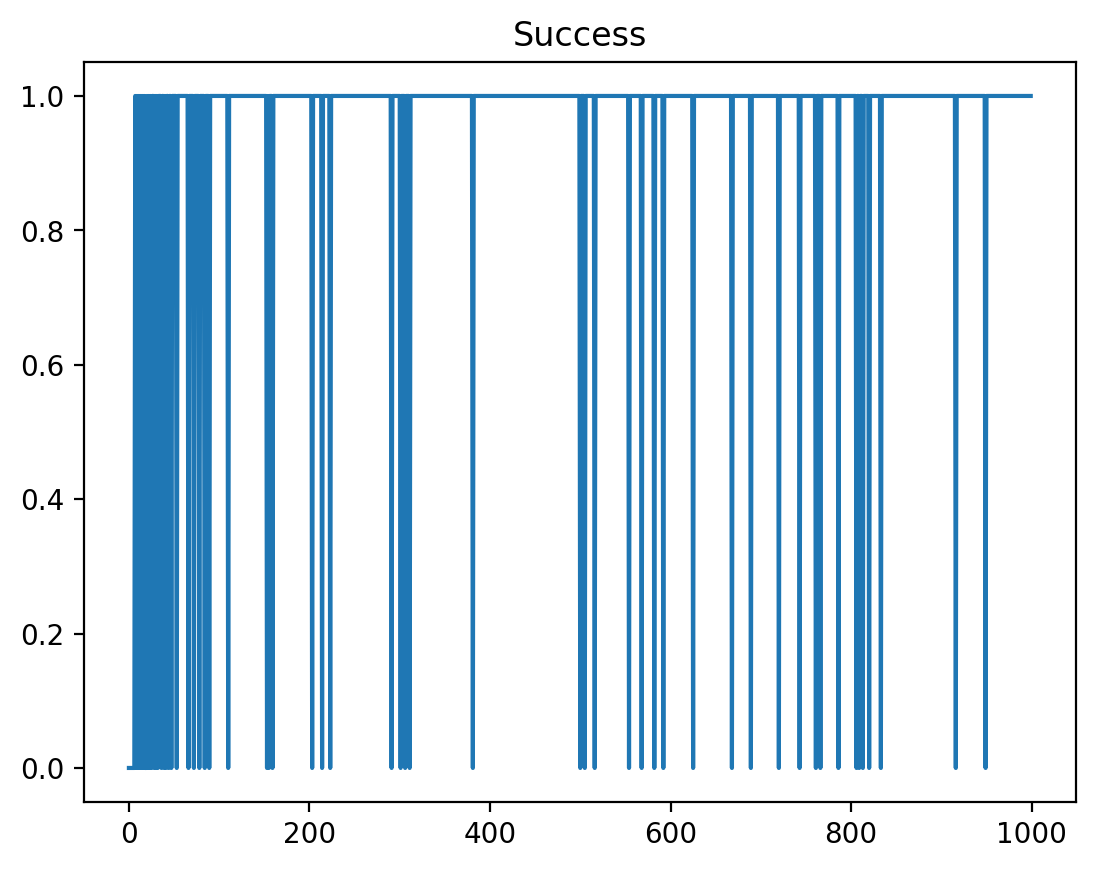

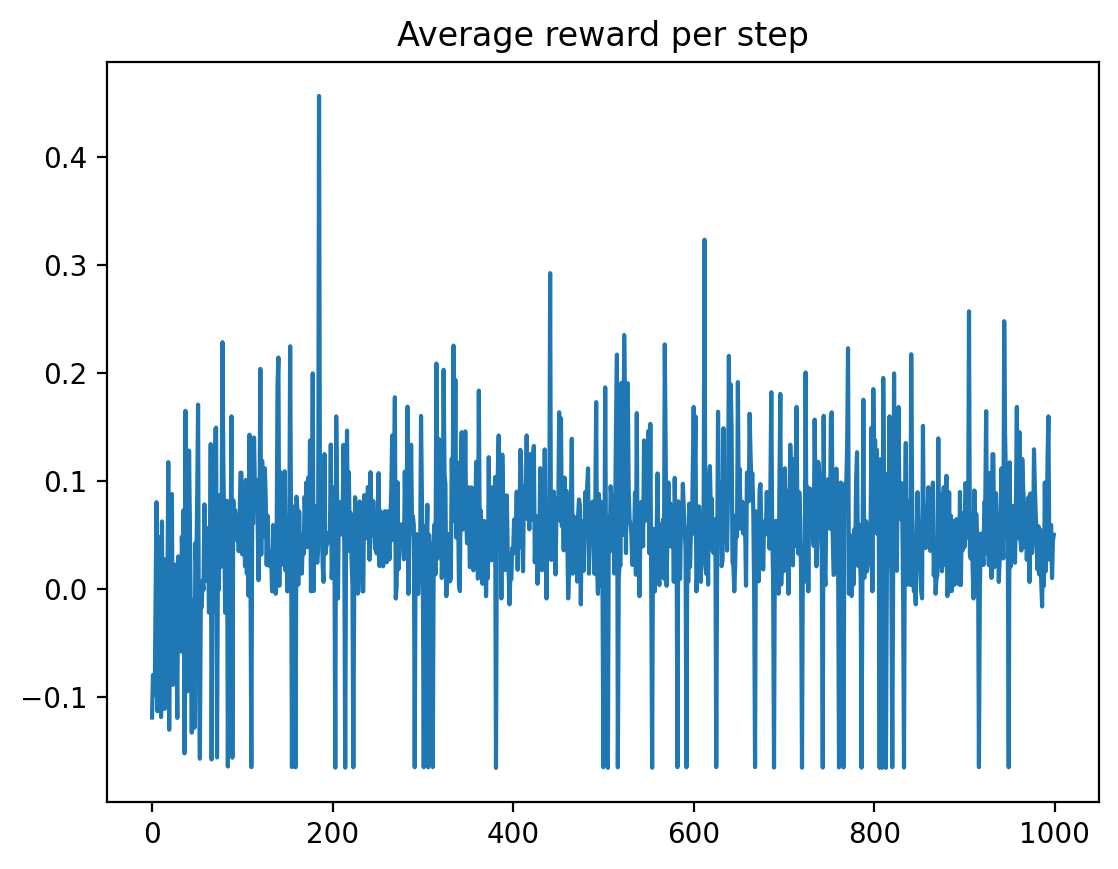

In [20]:
# @title Run cell to plot success and average true reward
plt.figure()
plt.plot(successes)
plt.title('Success')
plt.show()
plt.plot(rewards)
plt.title('Average reward per step')
plt.show()

In [21]:
# @title Run cell to visualize learned agent
def visualize(env, q_net, ep_steps):
    # Simulate agent in environment
    frames = []
    state = env.reset()
    for s in range(ep_steps):
        Q = q_net(torch.tensor(state, dtype=torch.float))
        action = epsilon_greedy(Q, epsilon)
        next_state, _, done, _ = env.step(action)

        display.clear_output(wait=True)
        frames.append(env.render('rgb_array'))
        state = next_state
        if done:
            break
    
    # Generate video
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')
    animate = lambda i: patch.set_data(frames[i])
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=range(len(frames)), interval=50)
    plt.close() # avoid showing extra plots
    return anim
    
visualize(env, q_net, 200)

Output hidden; open in https://colab.research.google.com to view.

# Section 3: Ethics


## Part I: Societal Context of DRL: Perspective from Practitioners & Scholars
 
As the practical applications of Deep Reinforcement Learning continue to grow, practitioners and scholars are raising awareness of the potential societal and ethical risks and challenges that must be addressed.  To explore these issues, we will be reading excerpts from [The Societal Implications of Deep Reinforcement Learning](https://www.jair.org/index.php/jair/article/view/12360/26667) published in the *Journal of Artificial Intelligence Research*.
 
Read “Section 3: Challenges DRL Raises for Society, Ethics, and Governance,” which enumerates six specific areas of concern.  Select one of the concerns the authors identified and describe it below. Offer your analysis of why it is an important issue.
 

In [22]:
area_of_concern = "Instead of focus on one of the sections, I would like to discuss an interesting topic that spans several sections.  think a particularly interesting area of DRL that also presents new concerns is in continual learning systems. Although it spans all six, some of the major concerns they outlined are: difficulty in providing human oversight since the system is making decisions and learning at the same time; the need for immense amounts of data to continue the learning process and the impact this has on privacy; difficulty in ensuring safety and reliability since the system is not fixed but instead is always changing (although it is assumed to get 'better', it could begin to learn harmful solutions); " #@param {type:"string"}

try:t3;
except NameError: t3 = time.time()

Now, complete your reading of “Section 4: Avenues of Progress in DRL and their Implications,” “Section 5. Discussion” and “Section 6: Summary and Conclusion.”  Do the authors suggest any solutions to the concern you discussed above?  If so, describe their approach.  If not, do you have your own recommendation?


In [23]:
solution_to_concern = "Since I chose to discuss continual learning (CL), a specific solution to that concern is not address. However, since CL spans several problems, it thus spans several solutions. CL approaches are automatically designed to be generalizable and may be more robust based on the way they learn (although we need to be careful about what and how they learn). Second, CL systems are always learning so they can learn in the lab and then continue learning in real life situations. One solution could be to use to train a system and promote CL in the lab, then apply advanced sim2real approaches to translate between domains, and finally, allow it to continue to learn in real life with more supervision." #@param {type:"string"}

try:t4;
except NameError: t4 = time.time()

## Part II: Stakeholder Perspective: A Proposed Multi-Factor Analysis for Governmental Use of Autonomous Systems
 
Next, consider the broader real-world uses of autonomous systems from the perspective of various users, spanning from corporate entities to government agencies.  Government agencies face particular ethical and legal challenges when confronted with the choice between adopting an artificial intelligence system or continuing to have humans making the decisions.
 
Read Part IV and the Conclusion of [“A Framework for Governmental Use of Machine Learning”](https://www.acus.gov/sites/default/files/documents/Coglianese%20ACUS%20Final%20Report%20w%20Cover%20Page.pdf), produced by Professor Cary Coglianese, University of Pennsylvania Law School, for the Administrative Conference of the United States (ACUS) in December 2020, which analyses the uses and implications of AI systems in the government and proposes a framework for public officials to use in deciding when to adopt AI tools. 
 
The report proposes a **multifactor analysis method** for government agencies to choose between AI and the status quo. Write a response addressing the following questions. 
- Considering your prior reading on the societal implications of DRL, is this multifactored method effective when agencies are faced with the choice of whether or not to adopt an autonomous system? 
- Are the prongs proposed in the report sufficient to address the issue you analyzed above? Why or why not? 
- Are these consistent with the proposals of the authors in “The Societal Implications of Deep Reinforcement Learning”? If not, which one do you think would better address the societal concerns arising from DRL? Would you propose a different approach?  
- In what ways do DRL systems introduce additional concerns than other autonomous systems?

In [24]:
part_2_response = "To be honest, I do not see the clear relationship between these two papers. For example, in the first, the issues being addressed are in some sense more about the technical shortcomings of DRL and less about when to use it (except that we should choose not to use it when we cannot be confident that it will not diverge from its intended purpose). In the second paper, the pronged approach is simply about when to adopt ML. One could argue that a system that a DRL system that is unreliable (say when it is deployed from the lab and into the real world) and therefore \"inaccurate\", then it should not replace humans. But this is very weak and incredibly obvious. The prongs proposed are very vague in my opinion and don't seem to propose anything revolutionary. It seems to me that they are saying we could consider (1) only the accuracy, (2) the consequences and benefits (accuracy would surely be lumped in), and (3) a soft version where we rate based on + and -. To me, it seems obvious that any decision should be evaluated using a cost-benefit analysis. A far more meaningful discussion would have been on what is cost and what is benefit. I.e., as ref'd in the text, is accuracy a cost if its low and benefit if it is high? Is 'fairness' a cost or benefit? DRL systems do have particular concerns since they are made to learn from the environment (which is assumed to change) and make decisions based on some prescribed/learned policy to achieve a reward. These can all have an enormous impact on the outcomes of their behavior, as in the boat game example. Some solutions may be optimal for a particular reward but suboptimal for every other aspect of the env. " #@param {type:"string"}

try:t5;
except NameError: t5 = time.time()

# Submission

Once you're done, click on 'Share' and add the link to the box below. If you did not use CoLab, you can also upload the file or notebook in the form below.

In [27]:
link = 'https://colab.research.google.com/drive/1LVK7XV9DnD4CFEoAw5vN1Fpxz2mVdoqr?usp=sharing' #@param {type:"string"}

In [29]:
import time
import numpy as np
import urllib.parse
from IPython.display import IFrame


#@markdown #Run Cell to Show Airtable Form
#@markdown ##**Confirm your answers and then click "Submit"**


def prefill_form(src, fields: dict):
  '''
  src: the original src url to embed the form
  fields: a dictionary of field:value pairs,
  e.g. {"pennkey": my_pennkey, "location": my_location}
  '''
  prefill_fields = {}
  for key in fields:
      new_key = 'prefill_' + key
      prefill_fields[new_key] = fields[key]
  prefills = urllib.parse.urlencode(prefill_fields)
  src = src + prefills
  return src


#autofill fields if they are not present
#a missing pennkey and pod will result in an Airtable warning
#which is easily fixed user-side.
try: my_pennkey;
except NameError: my_pennkey = ""
try: my_pod;
except NameError: my_pod = "Select"
try: extension;
except NameError: extension = "Double Q-learning"
try: explanation;
except NameError: explanation = ""
try: ablation;
except NameError: ablation = ""
try: state_dimension;
except NameError: state_dimension = 0
try: num_actions;
except NameError: num_actions = 0
try: meaning;
except NameError: meaning = ""
try: area_of_concern;
except NameError: area_of_concern = ""
try: solution_to_concern;
except NameError: solution_to_concern = ""
try: part_2_response;
except NameError: part_2_response = ""
try: link;
except NameError: link = ""

fields = {"pennkey": my_pennkey,
          "pod": my_pod,
          "extension": extension,
          "explanation": explanation,
          "ablation": ablation,
          "state_dimension": state_dimension,
          "num_actions": num_actions,
          "meaning": meaning,
          "area_of_concern": area_of_concern,
          "solution_to_concern": solution_to_concern,
          "part_2_response": part_2_response,
          "link": link}

src = "https://airtable.com/embed/shrb6cgGnu17S8MhJ?"


#now instead of the original source url, we do: src = prefill_form(src, fields)
#display(IFrame(src = prefill_form(src, fields), width = 800, height = 400))
display.display(IFrame(src = prefill_form(src, fields), width = 800, height = 400))